In [1]:
from eyring_model import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import pandas as pd
import seaborn as sns

# some constants
kB = 1.380649 * 10**-23    # Boltzmann (m^2 kg / s^2 K)
h = 6.62607 * 10**-34      # Planck (m^2 kg / s)
R = 1.9858775 * 10**-3     # universal gas (kcal / mol K)

In [2]:
# input parameters
avg_T = 300
dH_barrier = 3.5
dS_barrier = -9/avg_T
dH_sigma = dH_barrier/3
dS_sigma = -dS_barrier/3
n_paths = 22000
area = 1e8
lam = 10
n_jumps = 200
delta = lam*n_jumps

In [3]:
# initialize arrays
T = np.array([250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350])
P_norm = np.zeros(len(T))
P_exp = np.zeros(len(T))

In [4]:
# run Eyring model for each temperature with normally distributed barriers
dist = 'norm'
params = {'mu' : np.array([dH_barrier, dS_barrier]),
          'cov': np.array([[dH_sigma**2, 0],
                           [0, dS_sigma**2]])}


for i, temp in tqdm(enumerate(T)):
    model = EyringModel(T=temp, A=area)
    for n in range(n_paths):
        model.add_Path(n_jumps=n_jumps, lam=lam)
        model.paths[n].generate_membrane_barriers(dist=dist, multi=True, dist_params=params)
        
    P_norm[i] = model.calculate_permeability() / 60 / 60 / 1000 * 10**9 * 10

0it [00:00, ?it/s]

11it [01:12,  6.61s/it]


$\ln{P} = \ln{A} - \frac{E_a}{RT}$

So, the slope $m = -\frac{E_a}{R}$ and the intercept $b = \ln{A}$

Or, in terms of the TST model: $\ln{P} = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B T}{h} \right)} + \frac{\Delta S_{eff}}{R} - \frac{\Delta H_{eff}}{RT}$

So, the slope $m = - \frac{\Delta H_{eff}}{R}$ and the intercept $b = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B T}{h} \right)} + \frac{\Delta S_{eff}}{R}$

But, the intercept still has a temperature dependence...

In [5]:
# perform linear fit of ln(P) vs 1/T
X = sm.add_constant(1/T)
ols1 = sm.OLS(np.log(P_norm), X)
results1 = ols1.fit()
b, m = results1.params
be, me = results1.bse

print('ln(P) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P) vs 1/T:
Arrhenius barrier to permeability, Ea: 5.01 +/- 0.02 kcal/mol
Arrhenius prefactor, ln(A): -0.43 +/- 0.03 A/s
Prediction for 305 K: -8.70


In [12]:
results1.summary()

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.988e+04
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           4.42e-19
Time:                        16:44:47   Log-Likelihood:                 35.456
No. Observations:                  11   AIC:                            -66.91
Df Residuals:                       9   BIC:                            -66.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4331      0.030    -14.319      0.000      -0.501      -0.365
x1         -2521.2961      8.921   -282.635      0.000   -2541.476   -2501.116
==============================================================================
Omnibus:                        0.149   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.928   Jarque-Bera (JB):                0.187
Skew:                          -0.186   Prob(JB):                        0.911
Kurtosis:                       2.481   Cond. No.                     2.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$\ln{\frac{P}{T}} = \ln{A} - \frac{E_a}{RT}$

So, the slope $m = -\frac{E_a}{R}$ and the intercept $b = \ln{A}$

Or, in terms of the TST model: $\ln{\frac{P}{T}} = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B}{h} \right)} + \frac{\Delta S_{eff}}{R} - \frac{\Delta H_{eff}}{RT}$

So, the slope $m = - \frac{\Delta H_{eff}}{R}$ and the intercept $b = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B}{h} \right)} + \frac{\Delta S_{eff}}{R}$

In [8]:
# perform linear fit of ln(P/T) vs 1/T
X = sm.add_constant(1/T)
ols2 = sm.OLS(np.log(P_norm/T), X)
results2 = ols2.fit()
b, m = results2.params
be, me = results2.bse

print('ln(P/T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P/T) vs 1/T:
Arrhenius barrier to permeability, Ea: 4.42 +/- 0.01 kcal/mol
Arrhenius prefactor, ln(A): -7.12 +/- 0.03 A/s
Prediction for 305 K: -14.43


In [11]:
results2.summary()

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.920e+04
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           2.69e-19
Time:                        16:44:36   Log-Likelihood:                 37.431
No. Observations:                  11   AIC:                            -70.86
Df Residuals:                       9   BIC:                            -70.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.1247      0.025   -281.892      0.000      -7.182      -7.068
x1         -2226.5916      7.455   -298.671      0.000   -2243.456   -2209.727
==============================================================================
Omnibus:                        0.855   Durbin-Watson:                   2.368
Prob(Omnibus):                  0.652   Jarque-Bera (JB):                0.505
Skew:                          -0.479   Prob(JB):                        0.777
Kurtosis:                       2.571   Cond. No.                     2.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$\ln{\left( \frac{P \delta h}{\lambda^2 k_B T} \right)} = \ln{A} - \frac{E_a}{RT}$

So, the slope $m = -\frac{E_a}{R}$ and the intercept $b = \ln{A}$

Or, in terms of the TST model: $\ln{\left( \frac{P \delta h}{\lambda^2 k_B T} \right)} = \frac{\Delta S_{eff}}{R} - \frac{\Delta H_{eff}}{RT}$

So, the slope $m = - \frac{\Delta H_{eff}}{R}$ and the intercept $b = \frac{\Delta S_{eff}}{R}$

In [9]:
# perform linear fit of ln(P*delta*h/lam^2*kB*T) vs 1/T
X = sm.add_constant(1/T)
ols3 = sm.OLS(np.log(P_norm*delta*h/lam**2/kB/T), X)
results3 = ols3.fit()
b, m = results3.params
be, me = results3.bse

print('ln(P*delta*h/lam^2*kB*T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P*delta*h/lam^2*kB*T) vs 1/T:
Arrhenius barrier to permeability, Ea: 4.42 +/- 0.01 kcal/mol
Arrhenius prefactor, ln(A): -27.89 +/- 0.03 A/s
Prediction for 305 K: -35.19


In [13]:
results3.summary()

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.920e+04
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           2.69e-19
Time:                        16:45:06   Log-Likelihood:                 37.431
No. Observations:                  11   AIC:                            -70.86
Df Residuals:                       9   BIC:                            -70.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -27.8890      0.025  -1103.435      0.000     -27.946     -27.832
x1         -2226.5916      7.455   -298.671      0.000   -2243.456   -2209.727
==============================================================================
Omnibus:                        0.855   Durbin-Watson:                   2.368
Prob(Omnibus):                  0.652   Jarque-Bera (JB):                0.505
Skew:                          -0.479   Prob(JB):                        0.777
Kurtosis:                       2.571   Cond. No.                     2.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

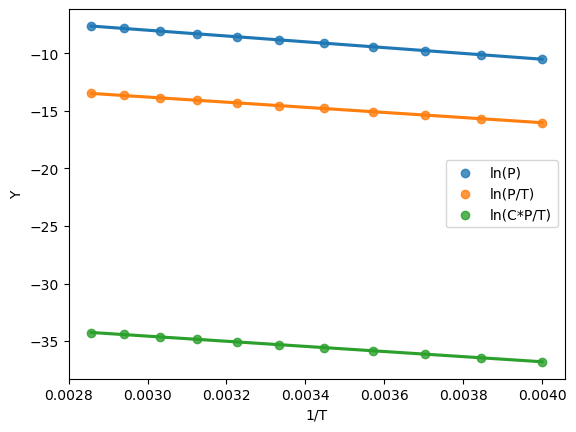

In [14]:
# plot linear fits
df = pd.DataFrame()
df['1/T'] = 1/T
df['ln(P)'] = np.log(P_norm)
df['ln(P/T)'] = np.log(P_norm/T)
df['ln(CP/T)'] = np.log(P_norm*delta*h/lam**2/kB/T)

fig, ax = plt.subplots(1,1)
sns.regplot(x='1/T', y='ln(P)', data=df, ax=ax, label='ln(P)')
sns.regplot(x='1/T', y='ln(P/T)', data=df, ax=ax, label='ln(P/T)')
sns.regplot(x='1/T', y='ln(CP/T)', data=df, ax=ax, label='ln(C*P/T)')

plt.ylabel('Y')
plt.legend();

In [15]:
# run Eyring model for each temperature with exponentially distributed barriers
dist = 'exp'
params = {'beta'  : np.array([dH_barrier, dS_barrier])}

for i, temp in tqdm(enumerate(T)):
    model = EyringModel(T=temp, A=area)
    for n in range(n_paths):
        model.add_Path(n_jumps=n_jumps, lam=lam)
        model.paths[n].generate_membrane_barriers(dist=dist, multi=True, dist_params=params)
        
    P_exp[i] = model.calculate_permeability() / 60 / 60 / 1000 * 10**9 * 10

11it [00:44,  4.09s/it]


In [16]:
# perform linear fit of ln(P) vs 1/T
X = sm.add_constant(1/T)
ols1 = sm.OLS(np.log(P_exp), X)
results1 = ols1.fit()
b, m = results1.params
be, me = results1.bse

print('ln(P) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P) vs 1/T:
Arrhenius barrier to permeability, Ea: 4.10 +/- 1.70 kcal/mol
Arrhenius prefactor, ln(A): -28.50 +/- 2.90 A/s
Prediction for 305 K: -35.26


In [17]:
results1.summary()

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     5.797
Date:                Mon, 27 Nov 2023   Prob (F-statistic):             0.0394
Time:                        16:55:55   Log-Likelihood:                -14.757
No. Observations:                  11   AIC:                             33.51
Df Residuals:                       9   BIC:                             34.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.4997      2.905     -9.811      0.000     -35.071     -21.928
x1         -2063.0263    856.846     -2.408      0.039   -4001.346    -124.707
==============================================================================
Omnibus:                        1.532   Durbin-Watson:                   2.629
Prob(Omnibus):                  0.465   Jarque-Bera (JB):                0.849
Skew:                           0.272   Prob(JB):                        0.654
Kurtosis:                       1.752   Cond. No.                     2.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
# perform linear fit of ln(P/T) vs 1/T
X = sm.add_constant(1/T)
ols2 = sm.OLS(np.log(P_exp/T), X)
results2 = ols2.fit()
b, m = results2.params
be, me = results2.bse

print('ln(P/T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P/T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.51 +/- 1.70 kcal/mol
Arrhenius prefactor, ln(A): -35.19 +/- 2.90 A/s
Prediction for 305 K: -40.99


In [19]:
results2.summary()

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     4.278
Date:                Mon, 27 Nov 2023   Prob (F-statistic):             0.0686
Time:                        16:55:56   Log-Likelihood:                -14.733
No. Observations:                  11   AIC:                             33.47
Df Residuals:                       9   BIC:                             34.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -35.1914      2.899    -12.141      0.000     -41.748     -28.634
x1         -1768.3219    854.962     -2.068      0.069   -3702.380     165.736
==============================================================================
Omnibus:                        1.564   Durbin-Watson:                   2.637
Prob(Omnibus):                  0.458   Jarque-Bera (JB):                0.851
Skew:                           0.263   Prob(JB):                        0.653
Kurtosis:                       1.743   Cond. No.                     2.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
# perform linear fit of ln(P*delta*h/lam^2*kB*T) vs 1/T
X = sm.add_constant(1/T)
ols3 = sm.OLS(np.log(P_exp*delta*h/lam**2/kB/T), X)
results3 = ols3.fit()
b, m = results3.params
be, me = results3.bse

print('ln(P*delta*h/lam^2*kB*T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P*delta*h/lam^2*kB*T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.51 +/- 1.70 kcal/mol
Arrhenius prefactor, ln(A): -55.96 +/- 2.90 A/s
Prediction for 305 K: -61.75


In [21]:
results3.summary()

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     4.278
Date:                Mon, 27 Nov 2023   Prob (F-statistic):             0.0686
Time:                        16:55:56   Log-Likelihood:                -14.733
No. Observations:                  11   AIC:                             33.47
Df Residuals:                       9   BIC:                             34.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -55.9556      2.899    -19.305      0.000     -62.513     -49.399
x1         -1768.3219    854.962     -2.068      0.069   -3702.380     165.736
==============================================================================
Omnibus:                        1.564   Durbin-Watson:                   2.637
Prob(Omnibus):                  0.458   Jarque-Bera (JB):                0.851
Skew:                           0.263   Prob(JB):                        0.653
Kurtosis:                       1.743   Cond. No.                     2.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

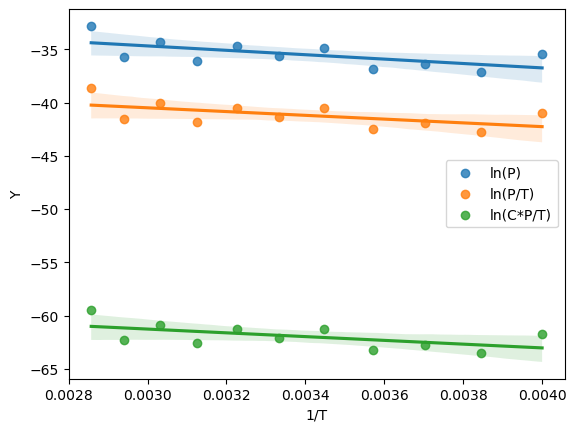

In [22]:
# plot linear fits
df = pd.DataFrame()
df['1/T'] = 1/T
df['ln(P)'] = np.log(P_exp)
df['ln(P/T)'] = np.log(P_exp/T)
df['ln(CP/T)'] = np.log(P_exp*delta*h/lam**2/kB/T)

fig, ax = plt.subplots(1,1)
sns.regplot(x='1/T', y='ln(P)', data=df, ax=ax, label='ln(P)')
sns.regplot(x='1/T', y='ln(P/T)', data=df, ax=ax, label='ln(P/T)')
sns.regplot(x='1/T', y='ln(CP/T)', data=df, ax=ax, label='ln(C*P/T)')

plt.ylabel('Y')
plt.legend();

In [25]:
# now the same analysis for the experimental data
df = pd.read_excel('../P_vs_T_results.xlsx')
df = df[df['system'] == 'NaCl (NF270)']
T = df['T (K)']
P_experiment = df['B (m/sec)']

In [26]:
# perform linear fit of ln(P) vs 1/T
X = sm.add_constant(1/T)
ols1 = sm.OLS(np.log(P_experiment), X)
results1 = ols1.fit()
b, m = results1.params
be, me = results1.bse

print('ln(P) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

print(results1.summary())

ln(P) vs 1/T:
Arrhenius barrier to permeability, Ea: 4.02 +/- 0.76 kcal/mol
Arrhenius prefactor, ln(A): -3.59 +/- 1.28 A/s
Prediction for 305 K: -10.24
                            OLS Regression Results                            
Dep. Variable:              B (m/sec)   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     28.03
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           7.27e-05
Time:                        12:27:17   Log-Likelihood:                 5.9381
No. Observations:                  18   AIC:                            -7.876
Df Residuals:                      16   BIC:                            -6.096
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|    

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [27]:
# perform linear fit of ln(P/T) vs 1/T
X = sm.add_constant(1/T)
ols2 = sm.OLS(np.log(P_experiment/T), X)
results2 = ols2.fit()
b, m = results2.params
be, me = results2.bse

print('ln(P/T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

print(results2.summary())

ln(P/T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.43 +/- 0.76 kcal/mol
Arrhenius prefactor, ln(A): -10.29 +/- 1.29 A/s
Prediction for 305 K: -15.96
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     20.37
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           0.000354
Time:                        12:27:18   Log-Likelihood:                 5.9331
No. Observations:                  18   AIC:                            -7.866
Df Residuals:                      16   BIC:                            -6.085
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t| 

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [28]:
# perform linear fit of ln(P*delta*h/lam^2*kB*T) vs 1/T
X = sm.add_constant(1/T)
ols3 = sm.OLS(np.log(P_experiment*delta*h/lam**2/kB/T), X)
results3 = ols3.fit()
b, m = results3.params
be, me = results3.bse

print('ln(P*delta*h/lam^2*kB*T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P*delta*h/lam^2*kB*T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.43 +/- 0.76 kcal/mol
Arrhenius prefactor, ln(A): -31.06 +/- 1.29 A/s
Prediction for 305 K: -36.72


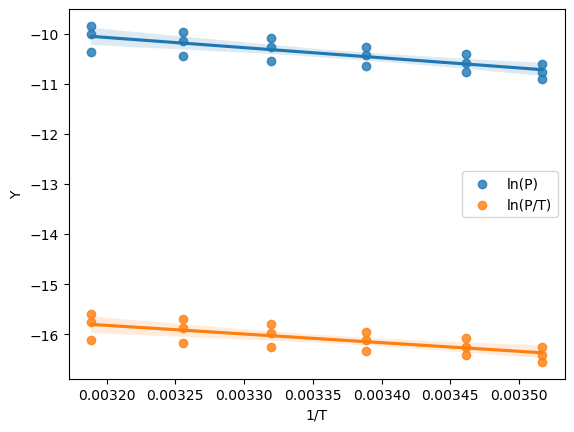

In [29]:
# plot the linear fits
df['1/T'] = 1/df['T (K)']
df['ln(P)'] = np.log(P_experiment)
df['ln(P/T)'] = np.log(P_experiment/T)
df['ln(CP/T)'] = np.log(P_experiment*delta*h/lam**2/kB/T)

fig, ax = plt.subplots(1,1)
sns.regplot(x='1/T', y='ln(P)', data=df, ax=ax, label='ln(P)', ci=95)
sns.regplot(x='1/T', y='ln(P/T)', data=df, ax=ax, label='ln(P/T)', ci=95)
# sns.regplot(x='1/T', y='ln(CP/T)', data=df, ax=ax, label='ln(C*P/T)')

plt.ylabel('Y')
plt.legend();

In [30]:
print(f'Sum of squared residuals for ln(P) vs 1/T: {results1.ssr}')
print(f'Sum of squared residuals for ln(P/T) vs 1/T: {results2.ssr}')

Sum of squared residuals for ln(P) vs 1/T: 0.5448210209390335
Sum of squared residuals for ln(P/T) vs 1/T: 0.5451251527821924


In [35]:
# now with the average permeabilities
df = pd.read_excel('../P_vs_T_results.xlsx')
df = df[df['system'] == 'NaCl (NF270)'].dropna()
T = df['T (K)']
P_experiment = df['ave B (m/sec)']

In [37]:
# perform linear fit of ln(P) vs 1/T
X = sm.add_constant(1/T)
ols1 = sm.OLS(np.log(P_experiment), X)
results1 = ols1.fit()
b, m = results1.params
be, me = results1.bse

print('ln(P) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

print(results1.summary())

ln(P) vs 1/T:
Arrhenius barrier to permeability, Ea: 4.11 +/- 0.18 kcal/mol
Arrhenius prefactor, ln(A): -3.43 +/- 0.31 A/s
Prediction for 305 K: -10.22
                            OLS Regression Results                            
Dep. Variable:          ave B (m/sec)   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     499.1
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           2.38e-05
Time:                        12:32:03   Log-Likelihood:                 14.647
No. Observations:                   6   AIC:                            -25.29
Df Residuals:                       4   BIC:                            -25.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|    

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [38]:
# perform linear fit of ln(P/T) vs 1/T
X = sm.add_constant(1/T)
ols2 = sm.OLS(np.log(P_experiment/T), X)
results2 = ols2.fit()
b, m = results2.params
be, me = results2.bse

print('ln(P/T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

print(results2.summary())

ln(P/T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.52 +/- 0.19 kcal/mol
Arrhenius prefactor, ln(A): -10.13 +/- 0.32 A/s
Prediction for 305 K: -15.94
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     352.3
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           4.74e-05
Time:                        12:32:21   Log-Likelihood:                 14.536
No. Observations:                   6   AIC:                            -25.07
Df Residuals:                       4   BIC:                            -25.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t| 

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [39]:
# perform linear fit of ln(P*delta*h/lam^2*kB*T) vs 1/T
X = sm.add_constant(1/T)
ols3 = sm.OLS(np.log(P_experiment*delta*h/lam**2/kB/T), X)
results3 = ols3.fit()
b, m = results3.params
be, me = results3.bse

print('ln(P*delta*h/lam^2*kB*T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P*delta*h/lam^2*kB*T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.52 +/- 0.19 kcal/mol
Arrhenius prefactor, ln(A): -30.89 +/- 0.32 A/s
Prediction for 305 K: -36.70


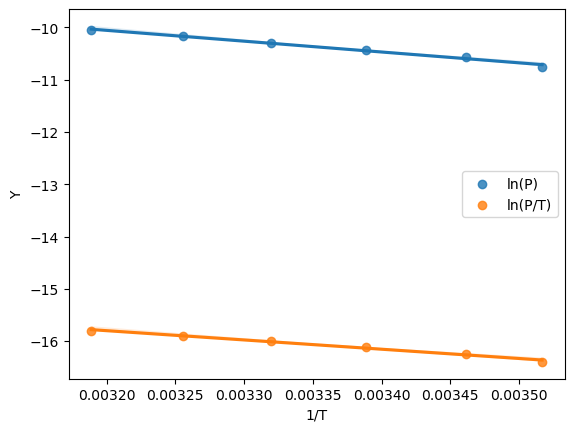

In [40]:
# plot the linear fits
df['1/T'] = 1/df['T (K)']
df['ln(P)'] = np.log(P_experiment)
df['ln(P/T)'] = np.log(P_experiment/T)
df['ln(CP/T)'] = np.log(P_experiment*delta*h/lam**2/kB/T)

fig, ax = plt.subplots(1,1)
sns.regplot(x='1/T', y='ln(P)', data=df, ax=ax, label='ln(P)', ci=95)
sns.regplot(x='1/T', y='ln(P/T)', data=df, ax=ax, label='ln(P/T)', ci=95)
# sns.regplot(x='1/T', y='ln(CP/T)', data=df, ax=ax, label='ln(C*P/T)')

plt.ylabel('Y')
plt.legend();

In [41]:
print(f'Sum of squared residuals for ln(P) vs 1/T: {results1.ssr}')
print(f'Sum of squared residuals for ln(P/T) vs 1/T: {results2.ssr}')

Sum of squared residuals for ln(P) vs 1/T: 0.0026625445905459357
Sum of squared residuals for ln(P/T) vs 1/T: 0.0027629163344016876
